In [23]:
import pandas as pd
import numpy as np



rest_data = pd.read_csv("./saves/2025-11-18_18-39-rest.csv", header = None)
rest_data = np.array(rest_data)

motion_data = pd.read_csv("./saves/2025-11-18_18-39-motioin.csv", header = None)
motion_data = np.array(motion_data)

rest_data.shape, motion_data.shape

((403, 3), (408, 3))

In [24]:
from scipy import signal

def emg_filter_pipeline(x, fs, band=(20, 90), notch=60, smooth_lp=5.0, order=4, rectify=False):
    x = np.asarray(x, dtype=float)
    nyq = fs * 0.5

    def _filtfilt(b, a, sig):
        return signal.filtfilt(b, a, sig, axis=0, method="gust")

    # Bandpass
    low, high = band
    high = min(high, nyq * 0.999)               # keep strictly < Nyquist
    assert 0 < low < high < nyq, "Invalid band edges for given fs."
    b_bp, a_bp = signal.butter(order, [low/nyq, high/nyq], btype="band")
    y = _filtfilt(b_bp, a_bp, x)

    # Notch 60Hz
    if notch is not None:
        w0 = notch / nyq
        # Quality factor: higher Q = narrower notch (30–50 works well for EMG mains hum)
        b_notch, a_notch = signal.iirnotch(w0, Q=30)
        y = _filtfilt(b_notch, a_notch, y)

    # Rectifying
    if rectify:
        y = np.abs(y)

    # Smoothing
    if smooth_lp is not None:
        cutoff = min(smooth_lp, nyq * 0.999)
        b_lp, a_lp = signal.butter(order, cutoff/nyq, btype="low")
        y = _filtfilt(b_lp, a_lp, y)

    return y


def spectral_subtract_background(x, noise_bg, fs, nperseg=512, noverlap=384, oversub=1.0, floor=0.05):
    x = np.asarray(x, dtype=float)
    noise_bg = np.asarray(noise_bg, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if noise_bg.ndim == 1:
        noise_bg = noise_bg[:, None]

    assert x.shape[1] == noise_bg.shape[1], "x and noise_bg must have same number of channels."

    y_out = np.zeros_like(x)
    win = signal.windows.hann(nperseg, sym=False)

    for c in range(x.shape[1]):
        f, t, Zx = signal.stft(x[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)
        _, _, Zn = signal.stft(noise_bg[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)

        mag_x = np.abs(Zx)
        phase_x = np.angle(Zx)
        # Average noise magnitude over time frames
        noise_mag = np.mean(np.abs(Zn), axis=1, keepdims=True)  # (F, 1)

        # Spectral subtraction
        clean_mag = mag_x - oversub * noise_mag
        # Flooring to avoid negative or too-small magnitudes
        clean_mag = np.maximum(clean_mag, floor * mag_x)

        # Reconstruct with original phase
        Z_clean = clean_mag * np.exp(1j * phase_x)
        _, y_c = signal.istft(Z_clean, fs=fs, window=win, nperseg=nperseg,
                              noverlap=noverlap, input_onesided=True, boundary=False)
        # Match length
        y_out[:len(y_c), c] = y_c

    return y_out.squeeze()


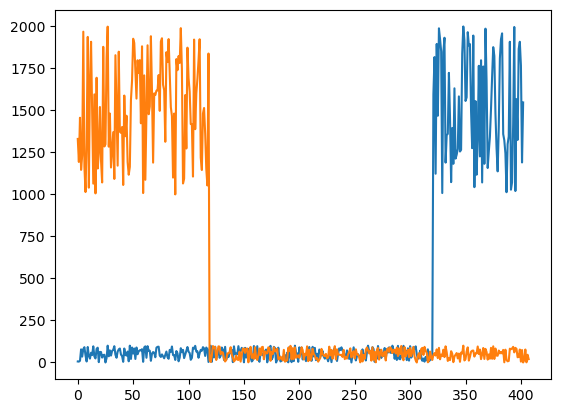

In [25]:
import matplotlib.pyplot as plt

d1 = rest_data[:, 0]
d2 = rest_data[:, 1]
d3 = rest_data[:, 2]

d11 = motion_data[:, 0]

plt.plot(d1)
plt.plot(d11)
plt.show()


In [29]:
import numpy as np
from scipy import signal

def emg_filter_pipeline(x, fs, band=(20, 90), notch=60, smooth_lp=5.0, order=4, rectify=False):
    x = np.asarray(x, dtype=float)
    nyq = fs * 0.5

    def _filtfilt(b, a, sig):
        return signal.filtfilt(b, a, sig, axis=0, method="gust")

    # Bandpass
    low, high = band
    high = min(high, nyq * 0.999)               # keep strictly < Nyquist
    assert 0 < low < high < nyq, "Invalid band edges for given fs."
    b_bp, a_bp = signal.butter(order, [low/nyq, high/nyq], btype="band")
    y = _filtfilt(b_bp, a_bp, x)

    # Notch 60Hz
    if notch is not None:
        w0 = notch / nyq
        # Quality factor: higher Q = narrower notch (30–50 works well for EMG mains hum)
        b_notch, a_notch = signal.iirnotch(w0, Q=30)
        y = _filtfilt(b_notch, a_notch, y)

    # Rectifying
    if rectify:
        y = np.abs(y)

    # Smoothing
    if smooth_lp is not None:
        cutoff = min(smooth_lp, nyq * 0.999)
        b_lp, a_lp = signal.butter(order, cutoff/nyq, btype="low")
        y = _filtfilt(b_lp, a_lp, y)

    return y


def spectral_subtract_background(x, noise_bg, fs, nperseg=512, noverlap=384, oversub=1.0, floor=0.05):
    x = np.asarray(x, dtype=float)
    noise_bg = np.asarray(noise_bg, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if noise_bg.ndim == 1:
        noise_bg = noise_bg[:, None]

    assert x.shape[1] == noise_bg.shape[1], "x and noise_bg must have same number of channels."

    y_out = np.zeros_like(x)
    win = signal.windows.hann(nperseg, sym=False)

    for c in range(x.shape[1]):
        f, t, Zx = signal.stft(x[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)
        _, _, Zn = signal.stft(noise_bg[:, c], fs=fs, window=win, nperseg=nperseg,
                               noverlap=noverlap, boundary=None)

        mag_x = np.abs(Zx)
        phase_x = np.angle(Zx)
        # Average noise magnitude over time frames
        noise_mag = np.mean(np.abs(Zn), axis=1, keepdims=True)  # (F, 1)

        # Spectral subtraction
        clean_mag = mag_x - oversub * noise_mag
        # Flooring to avoid negative or too-small magnitudes
        clean_mag = np.maximum(clean_mag, floor * mag_x)

        # Reconstruct with original phase
        Z_clean = clean_mag * np.exp(1j * phase_x)
        _, y_c = signal.istft(Z_clean, fs=fs, window=win, nperseg=nperseg,
                              noverlap=noverlap, input_onesided=True, boundary=False)
        # Match length
        y_out[:len(y_c), c] = y_c

    return y_out.squeeze()


def pipeline(x, noise, fs, band=(20, 90), notch=20, order=4, nperseg=512, noverlap=384, oversub=1.0, floor=0.05):
    filtered_x = emg_filter_pipeline(x, fs, band, notch, None, order, False)
    filtered_n = emg_filter_pipeline(noise, fs, band, notch, None, order, False)
    y = spectral_subtract_background(filtered_x, filtered_n, fs, nperseg, noverlap, oversub, floor)
    return y


In [30]:
d = pipeline(d1, d11, fs=80)
plt.plot(d)
plt.show()

ValueError: window is longer than input signal